# 2020-21 gameweek 1 predictions

## Set-up

In [62]:
import os
import unidecode
import difflib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [2]:
os.chdir('../..')

In [3]:
from src.models.DeepFantasyFootball.make_predictions import DeepFantasyFootball, load_live_data, SEASON_ORDER_DICT
from src.data.s3_utilities import s3_filesystem

Using TensorFlow backend.


In [58]:
pd.options.display.max_columns = None

## Make predictions

In [4]:
%%time
live_data = load_live_data()

2020-09-06 22:32:03,625 - Loading historical FFS data
2020-09-06 22:32:10,145 - Loaded historical FFS data of shape (92410, 66)
2020-09-06 22:32:10,146 - Loading latest FFS data
2020-09-06 22:32:10,520 - No data for 2020-2021 available, returning empty DataFrame for latest FFS data
2020-09-06 22:32:10,524 - Loaded latest FFS data of shape: Empty DataFrame
Columns: []
Index: []
2020-09-06 22:32:10,603 - Combined FFS data shape:       Team  Aerial Duels - Won - Percentage  Assists  Big Chances Created  \
0      ARS                             75.0        0                    0   
1      QPR                             40.0        0                    0   
2      ARS                              0.0        0                    0   
3      MUN                              0.0        0                    0   
4      CHE                              0.0        0                    1   
...    ...                              ...      ...                  ...   
92405  EVE                    

CPU times: user 1.96 s, sys: 760 ms, total: 2.72 s
Wall time: 13.8 s


In [5]:
live_data.head()

,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,...,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points,season_order
0,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.21,0.0,0,0,1,0,0,0,0.0,4
25,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.34,1.0,0,0,1,0,0,0,0.0,4
50,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.23,1.0,0,0,1,0,0,0,0.0,4
75,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.14,0.0,1,0,1,0,0,0,1.0,4
100,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2.26,1.0,0,0,1,0,0,0,1.0,4


In [6]:
PREVIOUS_GW = 38
PREDICTION_SEASON = '2019-20'
PREDICTION_SEASON_ORDER = SEASON_ORDER_DICT[PREDICTION_SEASON]

In [7]:
lstm_pred = DeepFantasyFootball(
    previous_gw=PREVIOUS_GW,
    prediction_season_order=PREDICTION_SEASON_ORDER,
    previous_gw_was_double_gw=False  # Remove parameter
)

In [8]:
player_list, player_data_list = lstm_pred.prepare_data_for_lstm(full_data=live_data)

2020-09-06 22:32:48,217 - Number of players available for selection: 70443.0
2020-09-06 22:32:48,384 - Player data shape before: (70443, 66)
2020-09-06 22:32:48,506 - Player data shape after removing players with insufficient GW data: (70443, 66)
2020-09-06 22:32:49,052 - Player data shape after only keeping records needed for LSTM: (2575, 66)


In [9]:
unformatted_predictions = lstm_pred.make_player_predictions(
    player_data_list=player_data_list
)

2020-09-06 22:32:51,541 - LSTM input array shape: (515, 5, 62)


In [10]:
final_predictions = lstm_pred.format_predictions(
    player_list=player_list,
    final_predictions=unformatted_predictions,
    full_data=live_data,
    double_gw_teams=[]
)

In [11]:
final_predictions.head(20)

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name
362,5.074889,5.093081,5.211715,5.165699,5.033885,25.579269,mohamed_salah,0,0,0,1,Liverpool
417,4.765638,5.084386,4.875301,4.862562,4.754107,24.341995,raheem_sterling,0,0,0,1,Manchester City
190,4.644610,4.668168,4.687046,4.619576,4.524410,23.143810,harry_kane,0,1,0,0,Tottenham Hotspur
31,5.086345,4.403208,4.416041,4.244920,4.093519,22.244034,andrew_robertson,1,0,0,0,Liverpool
144,4.245318,4.470252,4.302906,4.281700,4.146021,21.446198,ederson_santana de moraes,0,0,1,0,Manchester City
199,4.494442,4.342421,4.314094,4.194953,4.088878,21.434788,hugo_lloris,0,0,1,0,Tottenham Hotspur
294,4.466508,4.439493,4.233994,4.149983,4.022705,21.312681,kevin_de bruyne,0,0,0,1,Manchester City
26,4.659585,4.246092,4.243392,4.112785,3.969540,21.231394,alisson_ramses becker,0,0,1,0,Liverpool
174,4.246172,4.417510,4.188033,4.192812,4.105856,21.150385,gabriel_fernando de jesus,0,1,0,0,Manchester City
231,4.330534,4.296439,4.205321,4.142021,3.969203,20.943518,jamie_vardy,0,1,0,0,Leicester City


In [12]:
final_predictions[final_predictions['sum'].isnull()]['team_name'].unique()

array(['Bournemouth', 'Watford', 'Norwich City'], dtype=object)

In [13]:
final_predictions[~final_predictions['sum'].isnull()].tail(20)

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name
278,0.151056,0.273411,0.337332,0.401862,0.449787,1.613448,josé_ignacio peleteiro ramallo,0,0,0,1,Aston Villa
317,0.138740,0.258228,0.321462,0.384094,0.428348,1.530872,luke_freeman,0,0,0,1,Sheffield United
420,0.138740,0.258228,0.321462,0.384094,0.428348,1.530872,ravel_morrison,0,0,0,1,Sheffield United
369,0.138740,0.258228,0.321462,0.384094,0.428348,1.530872,muhamed_besic,0,0,0,1,Sheffield United
213,0.138740,0.258228,0.321462,0.384094,0.428348,1.530872,jack_rodwell,0,0,0,1,Sheffield United
77,0.138740,0.258228,0.321462,0.384094,0.428348,1.530872,callum_robinson,0,0,0,1,Sheffield United
18,0.190333,0.236076,0.324401,0.364727,0.413803,1.529340,albian_ajeti,0,1,0,0,West Ham United
465,0.105577,0.272278,0.325613,0.394038,0.429402,1.526907,steven_alzate,0,0,0,1,Brighton and Hove Albion
501,0.165257,0.239455,0.319610,0.369540,0.422868,1.516730,wesley_moraes ferreira da silva,0,1,0,0,Aston Villa
260,0.165257,0.239455,0.319610,0.369540,0.422868,1.516730,jonathan_kodjia,0,1,0,0,Aston Villa


In [14]:
final_predictions.groupby('position_MID').mean().loc[1]['sum']

7.592229843139648

In [15]:
final_predictions.groupby('position_FWD').mean().loc[1]['sum']

8.34713363647461

In [16]:
final_predictions.groupby('position_DEF').mean().loc[1]['sum']

7.791881084442139

In [17]:
final_predictions.groupby('position_GK').mean().loc[1]['sum']

10.678083419799805

In [18]:
old_model_predictions = pq.read_table(
    's3://fpl-analysis-data/gw_predictions/season=2020-21/gw=1/95fe694d21c04484a2b2cab2d81419a0.parquet', 
    filesystem=s3_filesystem
).to_pandas()

In [19]:
old_model_predictions.head(20)

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,next_match_value,model
0,7.030556,6.761380,6.777621,6.667402,6.692840,33.929798,kevin_de bruyne,0,0,0,1,Manchester City,11.5,lstm_v4
1,6.319860,6.077927,6.090129,5.983685,6.004195,30.475794,raheem_sterling,0,0,0,1,Manchester City,11.5,lstm_v4
2,5.657178,5.443412,5.453287,5.351354,5.367841,27.273075,mohamed_salah,0,0,0,1,Liverpool,12.0,lstm_v4
3,4.935556,4.740576,4.740447,4.639941,4.648809,23.705330,gabriel fernando_de jesus,0,1,0,0,Manchester City,9.5,lstm_v4
4,4.922827,4.734571,4.737661,4.639350,4.649484,23.683895,sadio_mané,0,0,0,1,Liverpool,12.0,lstm_v4
5,4.798070,4.609890,4.609621,4.510372,4.518536,23.046490,bruno miguel_borges fernandes,0,0,0,1,Manchester United,10.5,lstm_v4
6,4.678135,4.494624,4.493752,4.395195,4.402573,22.464281,anthony_martial,0,1,0,0,Manchester United,9.0,lstm_v4
7,4.679602,4.493706,4.491284,4.391965,4.398650,22.455206,harry_kane,0,1,0,0,Tottenham Hotspur,10.5,lstm_v4
8,4.673827,4.489105,4.487793,4.388762,4.395951,22.435436,jamie_vardy,0,1,0,0,Leicester City,10.0,lstm_v4
9,4.516146,4.338603,4.335416,4.238196,4.243636,21.671997,pierre-emerick_aubameyang,0,0,0,1,Arsenal,12.0,lstm_v4


## Merge predictions

In [29]:
final_predictions.shape

(515, 13)

In [30]:
old_model_predictions.shape

(655, 15)

In [22]:
final_predictions['name_formatted'] = final_predictions['name'].str.replace(' ', '_').apply(lambda string: unidecode.unidecode(string))

In [23]:
old_model_predictions['name_formatted'] = old_model_predictions['name'].str.replace(' ', '_').apply(lambda string: unidecode.unidecode(string))

### Look for closest name match

The mismatched names in `right_only` should have a close match to a name in `left_only`. We use `difflib` to find these.

In [24]:
name_matches = old_model_predictions[['name_formatted']].merge(final_predictions['name_formatted'], on='name_formatted', how='outer', indicator=True)
name_matches.head()

,name_formatted,_merge
0,kevin_de_bruyne,both
1,raheem_sterling,both
2,mohamed_salah,both
3,gabriel_fernando_de_jesus,both
4,sadio_mane,both


In [27]:
name_matches.loc[name_matches['_merge'] == 'right_only', 'name_closest_fpl_match'] = name_matches.loc[name_matches['_merge'] == 'right_only', 'name_formatted'].apply(
    lambda x: difflib.get_close_matches(
        x,
        name_matches[name_matches['_merge'] == 'left_only']['name_formatted'], 
        n=1, 
        cutoff=0  # Set to 0 to prevent empty list from being returned
    )[0]
)

Set cut-off of similarity to zero to reduce risk of empty list (i.e. no matches). We can join on team name and closest name to mitigate the chance of merging predictions for the wrong player.

In [28]:
name_matches.head()

,name_formatted,_merge,name_closest_fpl_match
0,kevin_de_bruyne,both,NaN
1,raheem_sterling,both,NaN
2,mohamed_salah,both,NaN
3,gabriel_fernando_de_jesus,both,NaN
4,sadio_mane,both,NaN


In [31]:
final_predictions.shape

(515, 13)

In [32]:
final_predictions = final_predictions.merge(name_matches, on='name_formatted', how='left')
print(final_predictions.shape)
final_predictions.head()

(515, 15)


,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,name_formatted,_merge,name_closest_fpl_match
0,5.074889,5.093081,5.211715,5.165699,5.033885,25.579269,mohamed_salah,0,0,0,1,Liverpool,mohamed_salah,both,NaN
1,4.765638,5.084386,4.875301,4.862562,4.754107,24.341995,raheem_sterling,0,0,0,1,Manchester City,raheem_sterling,both,NaN
2,4.644610,4.668168,4.687046,4.619576,4.524410,23.143810,harry_kane,0,1,0,0,Tottenham Hotspur,harry_kane,both,NaN
3,5.086345,4.403208,4.416041,4.244920,4.093519,22.244034,andrew_robertson,1,0,0,0,Liverpool,andrew_robertson,both,NaN
4,4.245318,4.470252,4.302906,4.281700,4.146021,21.446198,ederson_santana de moraes,0,0,1,0,Manchester City,ederson_santana_de_moraes,both,NaN


In [33]:
final_predictions.drop(columns=['_merge'], inplace=True)

In [36]:
final_predictions['name_join_key'] = np.where(
    final_predictions['name_closest_fpl_match'].isnull(),
    final_predictions['name_formatted'],
    final_predictions['name_closest_fpl_match']
)

In [37]:
assert final_predictions['name_join_key'].isnull().sum() == 0

### Align team names

In [38]:
set(old_model_predictions['team_name']) - set(final_predictions['team_name'])

{'Brighton & Hove Albion'}

In [39]:
set(final_predictions['team_name']) - set(old_model_predictions['team_name'])

{'Brighton and Hove Albion'}

In [42]:
team_data = pd.read_csv('data/external/team_season_data.csv')
team_data.head()

,team,team_name,promoted_side,top_6_last_season,season,team_name_ffs
0,1.0,Arsenal,0,1,2016-17,Arsenal
1,2.0,Bournemouth,0,0,2016-17,Bournemouth
2,3.0,Burnley,1,0,2016-17,Burnley
3,4.0,Chelsea,0,0,2016-17,Chelsea
4,5.0,Crystal Palace,0,0,2016-17,Crystal Palace


In [43]:
ffs_team_name_to_fpl = dict(
    zip(
        team_data[team_data['season'] == '2020-21']['team_name_ffs'],
        team_data[team_data['season'] == '2020-21']['team_name']
    )
)
ffs_team_name_to_fpl

{'Arsenal': 'Arsenal',
 'Aston Villa': 'Aston Villa',
 'Brighton and Hove Albion': 'Brighton & Hove Albion',
 'Burnley': 'Burnley',
 'Chelsea': 'Chelsea',
 'Crystal Palace': 'Crystal Palace',
 'Everton': 'Everton',
 'Fulham': 'Fulham',
 'Leicester City': 'Leicester City',
 'Leeds': 'Leeds',
 'Liverpool': 'Liverpool',
 'Manchester City': 'Manchester City',
 'Manchester United': 'Manchester United',
 'Newcastle United': 'Newcastle United',
 'Sheffield United': 'Sheffield United',
 'Southampton': 'Southampton',
 'Tottenham Hotspur': 'Tottenham Hotspur',
 'West Bromwich Albion': 'West Bromwich Albion',
 'West Ham United': 'West Ham United',
 'Wolverhampton Wanderers': 'Wolverhampton Wanderers'}

In [44]:
final_predictions['team_name'].replace(ffs_team_name_to_fpl, inplace=True)

In [48]:
set(final_predictions.columns) - set(old_model_predictions.columns)

{'name_closest_fpl_match', 'name_join_key'}

In [49]:
set(old_model_predictions.columns) - set(final_predictions.columns)

{'model', 'next_match_value'}

In [50]:
final_predictions.drop(columns=['name_closest_fpl_match'], inplace=True)
old_model_predictions.drop(columns=['model'], inplace=True)

In [51]:
combined = old_model_predictions.merge(
    final_predictions, 
    left_on=['name_formatted', 'team_name'], 
    right_on=['name_join_key', 'team_name'], 
    how='outer', 
    indicator=True, 
    suffixes=('_old', '_new')
)
combined.head()

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,...,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_join_key,_merge
0,7.030556,6.761380,6.777621,6.667402,6.692840,33.929798,kevin_de bruyne,0.0,0.0,0.0,...,4.022705,21.312681,kevin_de bruyne,0.0,0.0,0.0,1.0,kevin_de_bruyne,kevin_de_bruyne,both
1,6.319860,6.077927,6.090129,5.983685,6.004195,30.475794,raheem_sterling,0.0,0.0,0.0,...,4.754107,24.341995,raheem_sterling,0.0,0.0,0.0,1.0,raheem_sterling,raheem_sterling,both
2,5.657178,5.443412,5.453287,5.351354,5.367841,27.273075,mohamed_salah,0.0,0.0,0.0,...,5.033885,25.579269,mohamed_salah,0.0,0.0,0.0,1.0,mohamed_salah,mohamed_salah,both
3,4.935556,4.740576,4.740447,4.639941,4.648809,23.705330,gabriel fernando_de jesus,0.0,1.0,0.0,...,4.105856,21.150385,gabriel_fernando de jesus,0.0,1.0,0.0,0.0,gabriel_fernando_de_jesus,gabriel_fernando_de_jesus,both
4,4.922827,4.734571,4.737661,4.639350,4.649484,23.683895,sadio_mané,0.0,0.0,0.0,...,3.398149,17.836790,sadio_mane,0.0,0.0,0.0,1.0,sadio_mane,sadio_mane,both


In [52]:
combined['_merge'].value_counts()

both          505
left_only     150
right_only     10
Name: _merge, dtype: int64

In [53]:
combined[combined['_merge'] == 'right_only']

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,...,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_join_key,_merge
655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.411455,12.462458,kyle_walker-peters,1.0,0.0,0.0,0.0,kyle_walker-peters,kyle_walker-peters,right_only
656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.206870,11.381023,luke_thomas,1.0,0.0,0.0,0.0,luke_thomas,luke_amos,right_only
657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.952545,10.208894,diogo_josé teixeira da silva,0.0,1.0,0.0,0.0,diogo_jose_teixeira_da_silva,danilo_luiz_da_silva,right_only
658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.830793,9.393058,harry_wilson,0.0,0.0,0.0,1.0,harry_wilson,harry_wilson,right_only
659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.676854,8.696870,danny_rose,1.0,0.0,0.0,0.0,danny_rose,danny_rose,right_only
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.178706,6.480230,george_hirst,0.0,1.0,0.0,0.0,george_hirst,joe_hart,right_only
661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.127401,4.899055,ryan_bennett,1.0,0.0,0.0,0.0,ryan_bennett,ryan_bennett,right_only
662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.988983,4.555578,cedric_ricardo alves soares,1.0,0.0,0.0,0.0,cedric_ricardo_alves_soares,cedric_soares,right_only
663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.600711,2.411958,daniel_drinkwater,0.0,0.0,0.0,1.0,daniel_drinkwater,daniel_drinkwater,right_only
664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.537470,2.135699,patrick_roberts,0.0,0.0,0.0,1.0,patrick_roberts,patrick_roberts,right_only


In [60]:
combined = combined[combined['_merge'] != 'right_only']
print(combined.shape)
combined.head()

(655, 28)


,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_join_key,_merge
0,7.030556,6.761380,6.777621,6.667402,6.692840,33.929798,kevin_de bruyne,0.0,0.0,0.0,1.0,Manchester City,11.5,kevin_de_bruyne,4.466508,4.439493,4.233994,4.149983,4.022705,21.312681,kevin_de bruyne,0.0,0.0,0.0,1.0,kevin_de_bruyne,kevin_de_bruyne,both
1,6.319860,6.077927,6.090129,5.983685,6.004195,30.475794,raheem_sterling,0.0,0.0,0.0,1.0,Manchester City,11.5,raheem_sterling,4.765638,5.084386,4.875301,4.862562,4.754107,24.341995,raheem_sterling,0.0,0.0,0.0,1.0,raheem_sterling,raheem_sterling,both
2,5.657178,5.443412,5.453287,5.351354,5.367841,27.273075,mohamed_salah,0.0,0.0,0.0,1.0,Liverpool,12.0,mohamed_salah,5.074889,5.093081,5.211715,5.165699,5.033885,25.579269,mohamed_salah,0.0,0.0,0.0,1.0,mohamed_salah,mohamed_salah,both
3,4.935556,4.740576,4.740447,4.639941,4.648809,23.705330,gabriel fernando_de jesus,0.0,1.0,0.0,0.0,Manchester City,9.5,gabriel_fernando_de_jesus,4.246172,4.417510,4.188033,4.192812,4.105856,21.150385,gabriel_fernando de jesus,0.0,1.0,0.0,0.0,gabriel_fernando_de_jesus,gabriel_fernando_de_jesus,both
4,4.922827,4.734571,4.737661,4.639350,4.649484,23.683895,sadio_mané,0.0,0.0,0.0,1.0,Liverpool,12.0,sadio_mane,3.974388,3.493660,3.550422,3.420171,3.398149,17.836790,sadio_mane,0.0,0.0,0.0,1.0,sadio_mane,sadio_mane,both


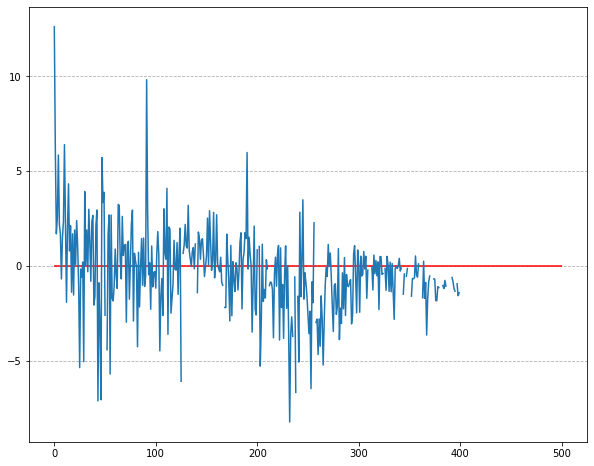

In [64]:
plt.figure(figsize=(10, 8))
plt.plot(combined['sum_old'] - combined['sum_new'])
plt.hlines(0, 0, 500, color='red')
plt.grid(axis='y', linestyle='--')
plt.show()

In [70]:
combined[np.abs(combined['sum_new'] - combined['sum_old']) >= 7]

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_join_key,_merge
0,7.030556,6.761380,6.777621,6.667402,6.692840,33.929798,kevin_de bruyne,0.0,0.0,0.0,1.0,Manchester City,11.5,kevin_de_bruyne,4.466508,4.439493,4.233994,4.149983,4.022705,21.312681,kevin_de bruyne,0.0,0.0,0.0,1.0,kevin_de_bruyne,kevin_de_bruyne,both
43,3.004309,2.883254,2.870653,2.782548,2.777399,14.318163,hugo_lloris,0.0,0.0,1.0,0.0,Tottenham Hotspur,5.5,hugo_lloris,4.494442,4.342421,4.314094,4.194953,4.088878,21.434788,hugo_lloris,0.0,0.0,1.0,0.0,hugo_lloris,hugo_lloris,both
46,2.959493,2.846015,2.843027,2.762198,2.762911,14.173645,alisson_ramses becker,0.0,0.0,1.0,0.0,Liverpool,6.0,alisson_ramses_becker,4.659585,4.246092,4.243392,4.112785,3.969540,21.231394,alisson_ramses becker,0.0,0.0,1.0,0.0,alisson_ramses_becker,alisson_ramses_becker,both
91,2.475207,2.394336,2.416959,2.359063,2.374500,12.020065,sergio_agüero,0.0,1.0,0.0,0.0,Manchester City,10.5,sergio_aguero,0.302146,0.391587,0.473718,0.496416,0.534871,2.198738,sergio_aguero,0.0,1.0,0.0,0.0,sergio_aguero,sergio_aguero,both
232,1.164610,1.135787,1.167962,1.130718,1.149233,5.748309,edward_nketiah,0.0,1.0,0.0,0.0,Arsenal,6.0,edward_nketiah,2.956449,2.869800,2.818228,2.740122,2.596318,13.980917,edward_nketiah,0.0,1.0,0.0,0.0,edward_nketiah,edward_nketiah,both


In [71]:
final_predictions.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,name_formatted,name_join_key
0,5.074889,5.093081,5.211715,5.165699,5.033885,25.579269,mohamed_salah,0,0,0,1,Liverpool,mohamed_salah,mohamed_salah
1,4.765638,5.084386,4.875301,4.862562,4.754107,24.341995,raheem_sterling,0,0,0,1,Manchester City,raheem_sterling,raheem_sterling
2,4.644610,4.668168,4.687046,4.619576,4.524410,23.143810,harry_kane,0,1,0,0,Tottenham Hotspur,harry_kane,harry_kane
3,5.086345,4.403208,4.416041,4.244920,4.093519,22.244034,andrew_robertson,1,0,0,0,Liverpool,andrew_robertson,andrew_robertson
4,4.245318,4.470252,4.302906,4.281700,4.146021,21.446198,ederson_santana de moraes,0,0,1,0,Manchester City,ederson_santana_de_moraes,ederson_santana_de_moraes


In [77]:
for feature in ['GW_plus_1', 'GW_plus_2', 'GW_plus_3', 'GW_plus_4', 'GW_plus_5', 'sum', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID']:
    combined[feature] = np.where(
        combined['sum_new'].isnull(),
        combined[f'{feature}_old'],
        combined[f'{feature}_new']
    )

combined['model'] = np.where(
    combined['sum_new'].isnull(),
    'lstm_v4',
    'DeepFantasyFootball_v01'
)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [78]:
combined.head()

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_join_key,_merge,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,position_DEF,position_FWD,position_GK,position_MID,model
0,7.030556,6.761380,6.777621,6.667402,6.692840,33.929798,kevin_de bruyne,0.0,0.0,0.0,1.0,Manchester City,11.5,kevin_de_bruyne,4.466508,4.439493,4.233994,4.149983,4.022705,21.312681,kevin_de bruyne,0.0,0.0,0.0,1.0,kevin_de_bruyne,kevin_de_bruyne,both,4.466508,4.439493,4.233994,4.149983,4.022705,21.312681,0.0,0.0,0.0,1.0,DeepFantasyFootball_v01
1,6.319860,6.077927,6.090129,5.983685,6.004195,30.475794,raheem_sterling,0.0,0.0,0.0,1.0,Manchester City,11.5,raheem_sterling,4.765638,5.084386,4.875301,4.862562,4.754107,24.341995,raheem_sterling,0.0,0.0,0.0,1.0,raheem_sterling,raheem_sterling,both,4.765638,5.084386,4.875301,4.862562,4.754107,24.341995,0.0,0.0,0.0,1.0,DeepFantasyFootball_v01
2,5.657178,5.443412,5.453287,5.351354,5.367841,27.273075,mohamed_salah,0.0,0.0,0.0,1.0,Liverpool,12.0,mohamed_salah,5.074889,5.093081,5.211715,5.165699,5.033885,25.579269,mohamed_salah,0.0,0.0,0.0,1.0,mohamed_salah,mohamed_salah,both,5.074889,5.093081,5.211715,5.165699,5.033885,25.579269,0.0,0.0,0.0,1.0,DeepFantasyFootball_v01
3,4.935556,4.740576,4.740447,4.639941,4.648809,23.705330,gabriel fernando_de jesus,0.0,1.0,0.0,0.0,Manchester City,9.5,gabriel_fernando_de_jesus,4.246172,4.417510,4.188033,4.192812,4.105856,21.150385,gabriel_fernando de jesus,0.0,1.0,0.0,0.0,gabriel_fernando_de_jesus,gabriel_fernando_de_jesus,both,4.246172,4.417510,4.188033,4.192812,4.105856,21.150385,0.0,1.0,0.0,0.0,DeepFantasyFootball_v01
4,4.922827,4.734571,4.737661,4.639350,4.649484,23.683895,sadio_mané,0.0,0.0,0.0,1.0,Liverpool,12.0,sadio_mane,3.974388,3.493660,3.550422,3.420171,3.398149,17.836790,sadio_mane,0.0,0.0,0.0,1.0,sadio_mane,sadio_mane,both,3.974388,3.493660,3.550422,3.420171,3.398149,17.836790,0.0,0.0,0.0,1.0,DeepFantasyFootball_v01


In [81]:
combined.sort_values('sum', ascending=False, inplace=True)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
combined.head(10)

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_join_key,_merge,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,position_DEF,position_FWD,position_GK,position_MID,model
2,5.657178,5.443412,5.453287,5.351354,5.367841,27.273075,mohamed_salah,0.0,0.0,0.0,1.0,Liverpool,12.0,mohamed_salah,5.074889,5.093081,5.211715,5.165699,5.033885,25.579269,mohamed_salah,0.0,0.0,0.0,1.0,mohamed_salah,mohamed_salah,both,5.074889,5.093081,5.211715,5.165699,5.033885,25.579269,0.0,0.0,0.0,1.0,DeepFantasyFootball_v01
1,6.319860,6.077927,6.090129,5.983685,6.004195,30.475794,raheem_sterling,0.0,0.0,0.0,1.0,Manchester City,11.5,raheem_sterling,4.765638,5.084386,4.875301,4.862562,4.754107,24.341995,raheem_sterling,0.0,0.0,0.0,1.0,raheem_sterling,raheem_sterling,both,4.765638,5.084386,4.875301,4.862562,4.754107,24.341995,0.0,0.0,0.0,1.0,DeepFantasyFootball_v01
7,4.679602,4.493706,4.491284,4.391965,4.398650,22.455206,harry_kane,0.0,1.0,0.0,0.0,Tottenham Hotspur,10.5,harry_kane,4.644610,4.668168,4.687046,4.619576,4.524410,23.143810,harry_kane,0.0,1.0,0.0,0.0,harry_kane,harry_kane,both,4.644610,4.668168,4.687046,4.619576,4.524410,23.143810,0.0,1.0,0.0,0.0,DeepFantasyFootball_v01
12,4.239182,4.072062,4.067756,3.971863,3.975711,20.326572,andrew_robertson,1.0,0.0,0.0,0.0,Liverpool,7.0,andrew_robertson,5.086345,4.403208,4.416041,4.244920,4.093519,22.244034,andrew_robertson,1.0,0.0,0.0,0.0,andrew_robertson,andrew_robertson,both,5.086345,4.403208,4.416041,4.244920,4.093519,22.244034,1.0,0.0,0.0,0.0,DeepFantasyFootball_v01
25,3.368312,3.233645,3.222417,3.131451,3.128231,16.084057,ederson_santana de moraes,0.0,0.0,1.0,0.0,Manchester City,6.0,ederson_santana_de_moraes,4.245318,4.470252,4.302906,4.281700,4.146021,21.446198,ederson_santana de moraes,0.0,0.0,1.0,0.0,ederson_santana_de_moraes,ederson_santana_de_moraes,both,4.245318,4.470252,4.302906,4.281700,4.146021,21.446198,0.0,0.0,1.0,0.0,DeepFantasyFootball_v01
43,3.004309,2.883254,2.870653,2.782548,2.777399,14.318163,hugo_lloris,0.0,0.0,1.0,0.0,Tottenham Hotspur,5.5,hugo_lloris,4.494442,4.342421,4.314094,4.194953,4.088878,21.434788,hugo_lloris,0.0,0.0,1.0,0.0,hugo_lloris,hugo_lloris,both,4.494442,4.342421,4.314094,4.194953,4.088878,21.434788,0.0,0.0,1.0,0.0,DeepFantasyFootball_v01
0,7.030556,6.761380,6.777621,6.667402,6.692840,33.929798,kevin_de bruyne,0.0,0.0,0.0,1.0,Manchester City,11.5,kevin_de_bruyne,4.466508,4.439493,4.233994,4.149983,4.022705,21.312681,kevin_de bruyne,0.0,0.0,0.0,1.0,kevin_de_bruyne,kevin_de_bruyne,both,4.466508,4.439493,4.233994,4.149983,4.022705,21.312681,0.0,0.0,0.0,1.0,DeepFantasyFootball_v01
46,2.959493,2.846015,2.843027,2.762198,2.762911,14.173645,alisson_ramses becker,0.0,0.0,1.0,0.0,Liverpool,6.0,alisson_ramses_becker,4.659585,4.246092,4.243392,4.112785,3.969540,21.231394,alisson_ramses becker,0.0,0.0,1.0,0.0,alisson_ramses_becker,alisson_ramses_becker,both,4.659585,4.246092,4.243392,4.112785,3.969540,21.231394,0.0,0.0,1.0,0.0,DeepFantasyFootball_v01
3,4.935556,4.740576,4.740447,4.639941,4.648809,23.705330,gabriel fernando_de jesus,0.0,1.0,0.0,0.0,Manchester City,9.5,gabriel_fernando_de_jesus,4.246172,4.417510,4.188033,4.192812,4.105856,21.150385,gabriel_fernando de jesus,0.0,1.0,0.0,0.0,gabriel_fernando_de_jesus,gabriel_fernando_de_jesus,both,4.246172,4.417510,4.188033,4.192812,4.105856,21.150385,0.0,1.0,0.0,0.0,DeepFantasyFootball_v01
8,4.673827,4.489105,4.487793,4.388762,4.395951,22.435436,jamie_vardy,0.0,1.0,0.0,0.0,Leicester City,10.0,jamie_vardy,4.330534,4.296439,4.205321,4.142021,3.969203,20.943518,jamie_vardy,0.0,1.0,0.0,0.0,jamie_vardy,jamie_vardy,both,4.330534,4.296439,4.205321,4.142021,3.969203,20.943518,0.0,1.0,0.0,0.0,DeepFantasyFootball_v01


In [88]:
combined.isnull().sum()

GW_plus_1_old         255
GW_plus_2_old         255
GW_plus_3_old         255
GW_plus_4_old         255
GW_plus_5_old         255
sum_old               255
name_old                0
position_DEF_old        0
position_FWD_old        0
position_GK_old         0
position_MID_old        0
team_name               0
next_match_value      255
name_formatted_old      0
GW_plus_1_new         231
GW_plus_2_new         231
GW_plus_3_new         231
GW_plus_4_new         231
GW_plus_5_new         231
sum_new               231
name_new              150
position_DEF_new      150
position_FWD_new      150
position_GK_new       150
position_MID_new      150
name_formatted_new    150
name_join_key         150
_merge                  0
GW_plus_1             203
GW_plus_2             203
GW_plus_3             203
GW_plus_4             203
GW_plus_5             203
sum                   203
position_DEF            0
position_FWD            0
position_GK             0
position_MID            0
model       

In [95]:
combined[~combined['sum'].isnull()]['model'].value_counts()

DeepFantasyFootball_v01    424
lstm_v4                     28
Name: model, dtype: int64